plots on geocoronal Ha
LVM sky subtraction busyweek, Dec 2024
Kathryn Kreckel

In [43]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from astropy.io import fits, ascii

from astropy.wcs import wcs
from astropy.table import Table

from scipy.ndimage import median_filter
from astropy.modeling import models, fitting

from astropy.stats import mad_std

from astropy.coordinates import SkyCoord  # High-level coordinates
import astropy.units as u
from astropy.time import Time

from scipy.optimize import curve_fit


import matplotlib as mpl
import pickle

from astropy.table import QTable
from astropy import table

import glob
import os
import datetime 
import scipy 

import astral
from astropy.time import Time, TimezoneInfo
from astropy.coordinates import AltAz, EarthLocation, get_sun
from astral.sun import sun
from datetime import date, time, timezone



from scipy.optimize import least_squares
from collections import Counter


#from shadow_height_lib import shadow_calc

In [2]:
font = {'size'   : 18}

mpl.rc('font', **font)

In [3]:
def forward(x):
    return x / 5.661e-18 # returns Rayleigh

def inverse(x):
    return x * 5.661e-18 # returns erg/s/cm^2/arcsec^2

Full fitting code is not shown, but available upon request. Resulting fits are compiled in the following fits file:


In [180]:
t = table.Table.read('saved_dictionary_geocoronal_v5.fits')  
drpall = table.Table.read('drpall-1.1.0.fits')

t.sort('frame')


In [183]:
scl=24.

whams = table.unique(t, keys='wham')
syms=['1','3','4','5','<','.','2','>','o','X']
dd ={}

for i,w in enumerate(whams):
    dd[w['wham']] = syms[i]


In [6]:
# shadow height in the drpall file seems to be incorrect, 
# this code  fixes it but takes a little bit of time to run

if False:
    from shadow_height_lib import shadow_calc

    # initialize the shadow height calculation
    s=shadow_calc()

    for dd in drpall:
        time = Time(dd['obstime'],format='isot', scale='utc')
        jj = time.jd

        cc = SkyCoord(dd['skye_ra'],dd['skye_dec'],frame='icrs',unit=u.deg)
        s.set_coordinates(cc.ra.deg,cc.dec.deg)
        s.update_time(jd=jj)
        dd['skye_sh_hght'] = s.get_heights(return_heights=True, unit="km")

        cc = SkyCoord(dd['skyw_ra'],dd['skyw_dec'],frame='icrs',unit=u.deg)
        s.set_coordinates(cc.ra.deg,cc.dec.deg)
        s.update_time(jd=jj)
        dd['skyw_sh_hght'] = s.get_heights(return_heights=True, unit="km")

        cc = SkyCoord(dd['sci_ra'],dd['sci_dec'],frame='icrs',unit=u.deg)
        s.set_coordinates(cc.ra.deg,cc.dec.deg)
        s.update_time(jd=jj)
        dd['sci_sh_hght'] = s.get_heights(return_heights=True, unit="km")

    #for tt in t:


/Users/kreckel/research/SDSSV/projects/sky_sub/geocoronal_figs/v1.1.0/shadow_height_lib.py:172: RuntimeWarning: All-NaN axis encountered
  self.dist[positive_delta] = np.nanmin([dist_b1[positive_delta], dist_b2[positive_delta]], axis=0)


**Columns in the astropy table based on the geocoronal line fits:**

* 'frame': exposure number
* 'mjd': MJD
* 'wham': name of the WHAM dark field
* 'center': geocoronal ha line centroid (A)
* 'flux': geocoronal ha line flux (erg/s/cm^2/arcsec^2)
* 'flux_err': geocoronal ha line flux (erg/s/cm^2/arcsec^2)
* 'stddev': geocoronal ha line broadening
* 'center6533': OH 6533 line centroid (A)
* 'flux6533': OH 6553 line flux (erg/s/cm^2/arcsec^2)
* 'center6554': OH 6554 line centroid (A)
* 'flux6554': OH 6554 line flux (erg/s/cm^2/arcsec^2)
* 'am': airmass
* 'hz': shadow height (km)
* 'filename': filename
* 'sky': which sky telescope
* 'baseline': median continuum level of sky spectrum (erg/s/cm^2/A/Fiber)
* 'rho': separation of Moon and object (deg)
* 'sun_alt': sun altitude (deg)
* 'time': time as astropy.time object
* 'solar_obsflux': Daily flux values are the radio emission from the Sun at a wavelength of 10.7 centimetres recorded daily (sfu = solar flux unit).
https://www.spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-5-en.php
https://www.spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-3-en.php

In [197]:
# Define the model
def model(params, x, nights):
    tau = params[0]  # First parameter is tau
    r0 = params[1:len(np.unique(nights)) + 1]  # Normalization for each night
    rbgr = params[len(np.unique(nights)) + 1:]  # Background for each night
    # Calculate the exponential function for each night
    return r0[nights.astype(int)] * np.exp(-x / tau) + rbgr[nights.astype(int)]


# Define the residual function
def residuals(params, x, y, nights):
    return model(params, x, nights) - y



Fitted scale length (tau): 1.373355264739361
Fitted normalization (r0): [ 5.02821229e+00  4.95986241e+00  6.25986901e+00  4.27965715e+00
  5.41299655e+00  4.93432270e+00  4.30475242e+00  6.28759666e+00
  9.14220034e+00  6.70238552e+00  4.99643589e+00  4.58827308e+00
  5.45987337e+00  4.30776648e+00  5.48601849e+00  5.07679787e+00
  5.41340141e+00  4.13063976e+00  4.73861409e+00  2.65957055e+00
  3.93841895e+00  3.73044479e+00  2.35904789e+00  3.82415657e+01
  1.14796422e-01 -1.82616932e+00  1.84634647e-01  1.10350531e+01
  9.79054852e+00  8.84630846e+00  5.57382320e+00  6.98130569e+00
  5.75565432e+00  5.84766004e+00  5.99038860e+00  8.13840825e+00
  6.32505018e+00  4.36959837e+00  5.50895363e+00  3.56646468e+00
  5.79746746e+00  5.41803558e+00  5.52559083e+00  4.51023468e+00
  5.57304869e+00  1.14471041e+01  8.15593643e+00  7.50570219e+00
  5.55510466e+00  4.63184597e+00  1.06338784e+01  5.33759749e+00
  5.36269041e+00  4.88627885e+00  4.95051021e+00  4.75448634e+00
  5.67094079e+00  

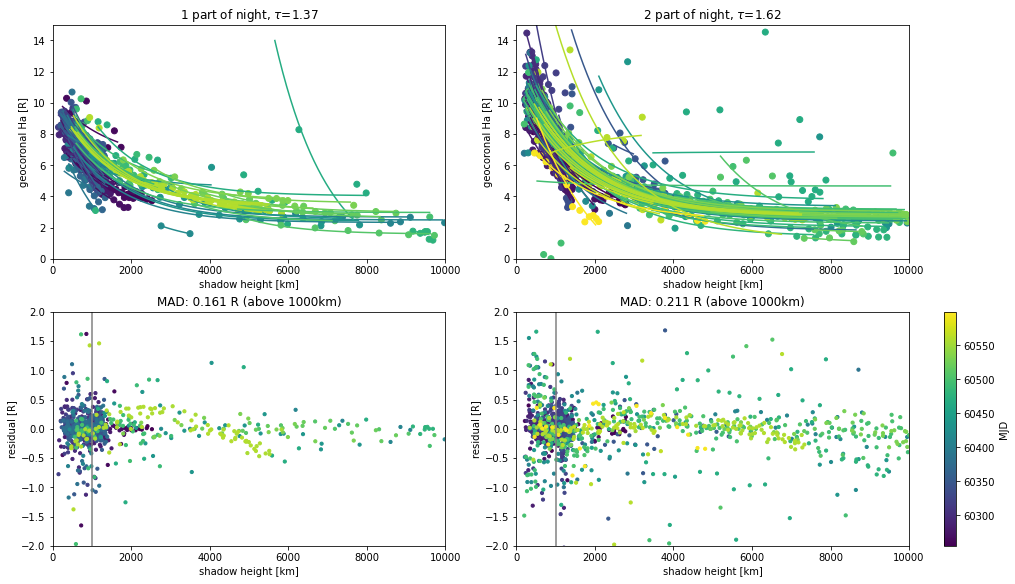

In [199]:
# fit each night with a function where the tau are tied, but r0 and r_bgr are only fit to individual half-nights

# organize the data

# Count the number of measurements for each unique night
night_counts = Counter(t['mjd'])

# Create a boolean array: True if a night has more than 5 measurements, otherwise False
night_has_more_than_5 = np.array([night_counts[n] > 5 for n in t['mjd']])

#(t['moon_alt'] < 0) & 
#& (t['wham'] != 'WHAM_south_08')
iis1 = (t['time'].data[:,1]*24 < -8) & night_has_more_than_5 & (t['hz'] < 10000) # first half of the night
iis2 = (t['time'].data[:,1]*24 >= -8) & night_has_more_than_5 & (t['hz'] < 10000)  # second half of the night

sub1 = t[iis1]
sub2 = t[iis2]


# Normalize the array vals so they can be mapped to a color
#c_norm = mpl.colors.Normalize(vmin=60200, vmax=60335)
c_norm = mpl.colors.Normalize(vmin=np.min(t['mjd']), vmax=np.max(t['mjd']))

# Pick a colormap
c_map  = mpl.cm.viridis

# Scalar mappable of normalized array to colormap
s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])


fig,axes = plt.subplots(2,2,layout='constrained', figsize=(14, 8))

for inight,sub in enumerate([sub1,sub2]): # = t[iis]

    x_all = sub['hz'].data/1000.

    tau=0.14
    scl2 = np.exp(-1.*tau*(sub['am'].data-1))
    y_all = forward(sub['flux'].data*scl2) 
    y_res = y_all * np.nan

    nights = sub['mjd'].data

    # Step 1: Get the unique values of nights
    unique_nights = np.unique(nights)

    # Step 2: Create a mapping from unique values to integers
    night_to_index = {night: idx for idx, night in enumerate(unique_nights)}

    # Step 3: Map the original nights array to indices
    nights_indices = np.array([night_to_index[night] for night in nights])


    # Initial guesses
    tau_initial = 3.0  # Fixed scale length
    num_nights = len(np.unique(nights))
    initial_r0 = np.ones(num_nights) * 5  # Initial guess for r0
    initial_rbgr = np.zeros(num_nights)  # Initial guess for background
    initial_params = np.concatenate([[tau_initial], initial_r0, initial_rbgr])

    # Fit the data
    result = least_squares(residuals, initial_params, args=(x_all, y_all, nights_indices))

    # Extract fitted parameters
    fitted_tau = result.x[0]
    fitted_r0 = result.x[1:num_nights+1]
    fitted_rbgr = result.x[num_nights+1:]

    # Print results
    print(f"Fitted scale length (tau): {fitted_tau}")
    print(f"Fitted normalization (r0): {fitted_r0}")
    print(f"Fitted background (rbgr): {fitted_rbgr}")

    # Plot data and fit
    for i, night in enumerate(np.unique(nights)):
        mask = (nights == night)
        axes[0,inight].scatter(x_all[mask]*1000, y_all[mask], label=f"Night {int(night) + 1}",c=s_map.to_rgba(nights[mask]))
        ex = np.arange(np.min(x_all[mask]),np.max(x_all[mask]),.1)
        axes[0,inight].plot(ex*1000, fitted_r0[i] * np.exp(-1.*ex / fitted_tau) + fitted_rbgr[i],
                 label=f"Fit Night {int(night) + 1}",color=s_map.to_rgba(np.median(nights[mask])))
        y_res[mask] = y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i])
        axes[1,inight].scatter(x_all[mask]*1000., y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i]),c =s_map.to_rgba(nights[mask]),s=10 )

    axes[1,inight].axvline(1000,color='grey')       

    axes[0,inight].set_title(fr'{inight+1} part of night, $\tau$={fitted_tau:.2f}')
    stat_mad = mad_std(y_res[x_all > 1])
    axes[1,inight].set_title(f'MAD: {stat_mad:.3f} R (above 1000km)')

    axes[0,inight].set_xlabel("shadow height [km]")
    axes[0,inight].set_ylabel("geocoronal Ha [R]")
    axes[1,inight].set_xlabel("shadow height [km]")
    axes[1,inight].set_ylabel("residual [R]")
    axes[0,inight].set_xlim(0,10000)
    axes[0,inight].set_ylim(0,15)
    axes[1,inight].set_xlim(0,10000)
    axes[1,inight].set_ylim(-2,2)

plt.colorbar(s_map, label=r'MJD')


Fitted scale length (tau): 1.6204952957847631
Fitted normalization (r0): [  8.16558408   7.05835397   5.99766799  11.84622618 -16.19515526
   7.67687      9.67445362  12.56362428  15.52232061  14.26642182
  18.08595535  16.74604294  10.06843198   8.69834212   7.43878538
   9.04822462   9.90319769   9.31254904   7.9108557    3.45971579
  11.39622272   3.78597737   7.04687449   2.43430664   9.27002226
   2.64804104   9.57583036   5.90997659   9.40981419  11.20862212
  15.72397686  11.85415941  10.94006351  10.40704299   6.95870287
   8.41888831   5.22086886   4.06279196   9.09723802  11.28035344
  11.85850619   4.49607861   4.40874737   7.92861407   6.54051828
  12.60719178   2.88605152   2.39052396  -0.36780484  11.9661768
   9.01477503   7.90219489   7.30169462   6.04251821   5.95500149
   4.97142464   2.58471598   6.4119081   31.15727584   7.79912743
   5.11399212   5.46662759   5.05432707   6.61606149   5.93861242
  10.57574537  11.69560406   8.4386032   10.89794465   8.03210446
   6

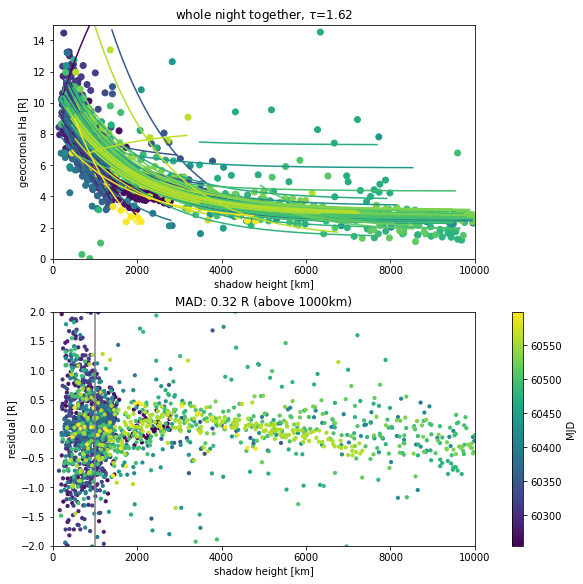

In [200]:
# fit each night with a function where the tau are tied, but r0 and r_bgr are only fit to individual half-nights

# organize the data

# Count the number of measurements for each unique night
night_counts = Counter(t['mjd'])

# Create a boolean array: True if a night has more than 5 measurements, otherwise False
night_has_more_than_5 = np.array([night_counts[n] > 5 for n in t['mjd']])

#(t['moon_alt'] < 0) & 
# & (t['wham'] != 'WHAM_south_08')
iis =  night_has_more_than_5 & (t['hz'] < 10000) # first half of the night
sub = t[iis]

# Normalize the array vals so they can be mapped to a color
#c_norm = mpl.colors.Normalize(vmin=60200, vmax=60335)
c_norm = mpl.colors.Normalize(vmin=np.min(t['mjd']), vmax=np.max(t['mjd']))

# Pick a colormap
c_map  = mpl.cm.viridis

# Scalar mappable of normalized array to colormap
s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])


fig,axes = plt.subplots(2,1,layout='constrained', figsize=(8, 8))

x_all = sub['hz'].data/1000.

tau=0.14
scl2 = np.exp(-1.*tau*(sub['am'].data-1))
y_all = forward(sub['flux'].data*scl2) 
y_res = y_all * np.nan

nights = sub['mjd'].data

# Step 1: Get the unique values of nights
unique_nights = np.unique(nights)

# Step 2: Create a mapping from unique values to integers
night_to_index = {night: idx for idx, night in enumerate(unique_nights)}

# Step 3: Map the original nights array to indices
nights_indices = np.array([night_to_index[night] for night in nights])


# Initial guesses
tau_initial = 3.0  # Fixed scale length
num_nights = len(np.unique(nights))
initial_r0 = np.ones(num_nights) * 5  # Initial guess for r0
initial_rbgr = np.zeros(num_nights)  # Initial guess for background
initial_params = np.concatenate([[tau_initial], initial_r0, initial_rbgr])

# Fit the data
result = least_squares(residuals, initial_params, args=(x_all, y_all, nights_indices))

# Extract fitted parameters
fitted_tau = result.x[0]
fitted_r0 = result.x[1:num_nights+1]
fitted_rbgr = result.x[num_nights+1:]

# Print results
print(f"Fitted scale length (tau): {fitted_tau}")
print(f"Fitted normalization (r0): {fitted_r0}")
print(f"Fitted background (rbgr): {fitted_rbgr}")

# Plot data and fit
for i, night in enumerate(np.unique(nights)):
    mask = (nights == night)
    axes[0].scatter(x_all[mask]*1000, y_all[mask], label=f"Night {int(night) + 1}",c=s_map.to_rgba(nights[mask]))
    ex = np.arange(np.min(x_all[mask]),np.max(x_all[mask]),.1)
    axes[0].plot(ex*1000, fitted_r0[i] * np.exp(-1.*ex / fitted_tau) + fitted_rbgr[i],
             label=f"Fit Night {int(night) + 1}",color=s_map.to_rgba(np.median(nights[mask])))
    y_res[mask] = y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i])
    axes[1].scatter(x_all[mask]*1000., y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i]),c =s_map.to_rgba(nights[mask]),s=10 )

axes[1].axvline(1000,color='grey')       

axes[0].set_title(fr'whole night together, $\tau$={fitted_tau:.2f}')
stat_mad = mad_std(y_res[x_all > 1])
axes[1].set_title(f'MAD: {stat_mad:.2f} R (above 1000km)')

axes[0].set_xlabel("shadow height [km]")
axes[0].set_ylabel("geocoronal Ha [R]")
axes[1].set_xlabel("shadow height [km]")
axes[1].set_ylabel("residual [R]")
axes[0].set_xlim(0,10000)
axes[0].set_ylim(0,15)
axes[1].set_xlim(0,10000)
axes[1].set_ylim(-2,2)

plt.colorbar(s_map, label=r'MJD')


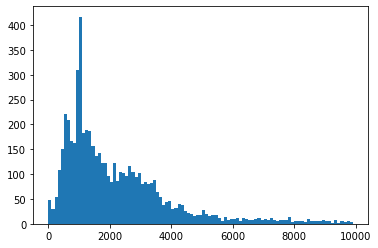

In [147]:
bins=np.arange(0,10000,100)
_=plt.hist(drpall['sci_sh_hght'],bins=bins)

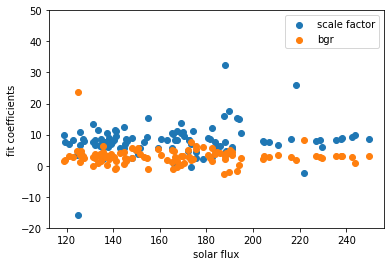

In [177]:
#print(len(unique_nights),len(fitted_r0), len(fitted_rbgr))

sol = []
for u in unique_nights:
    tmp = (t['mjd']==u)
    sol.append(t['solar_obsflux'][tmp][0])

plt.scatter(sol,fitted_r0,label='scale factor')
#plt.ylim(-50,50)

plt.scatter(sol,fitted_rbgr,label='bgr')
plt.ylim(-20,50)

plt.xlabel('solar flux')
plt.ylabel('fit coefficients')

plt.legend()